In [31]:
import awswrangler  as wr
import pandas as pd
import pymysql
import datetime
import requests
import json

# def lambda_handler(event, context):
sql = """
with order1 as (
select
a.reg_ts
, a.completed_at
, a.upd_ts
, a.id
, b.*
from moyo_order.mobile_plan_order a
join moyo_mart.order_statuskr_v1 b on a.status = b.status
where 1  =1
    and date( reg_ts ) >= date( '2023-08-01')
    and date( reg_ts ) < date( '2023-09-01')
)
, hist as (
select
a.*
, row_number( ) over( partition by mobile_plan_order_id order by reg_ts desc ) as rn
from moyo_order.mobile_plan_order_history a
join moyo_mart.order_statuskr_v1 b on a.status = b.status
where 1  =1
)
, raw1 as (
select
a.reg_ts
, b.reg_ts as hist_reg_ts
, a.completed_at
, b.status
, 1.00* date_diff ( 'minute', a.reg_ts , b.reg_ts ) as diff_hour
from order1 a
left join hist b on a.id = b.mobile_plan_order_id and b.rn = 1
where 1  =1
    and is_final = 1
    and final_type = 'canceled'
-- limit 100
)
select
*
from raw1

;


"""

df = wr.athena.read_sql_query(sql=sql, database="moyo_order")
# bucket = 'moyo-mart'

In [32]:
df.head()

,reg_ts,hist_reg_ts,completed_at,status,diff_hour
0,2023-08-26 19:59:56,2023-09-06 15:15:59,2023-08-29 09:39:54,ACTIVATION_CANCELED,15556.0
1,2023-08-01 17:04:58,2023-08-03 16:37:51,NaT,APPLICATION_REJECTED,2852.0
2,2023-08-01 17:18:42,2023-08-04 09:10:19,NaT,APPLICATION_REJECTED,3831.0
3,2023-08-03 20:45:47,2023-09-05 17:46:00,NaT,APPLICATION_REJECTED,47340.0
4,2023-08-05 14:17:31,2023-09-05 17:46:00,NaT,APPLICATION_REJECTED,44848.0


In [33]:
import numpy as np 

In [34]:
# y 축을 percentile 로 표준화하여 분포를 표현 
def ecdf(data) :
    n = len(data) 
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y

In [35]:
x,y =  ecdf(df.diff_hour)

In [36]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'minute')

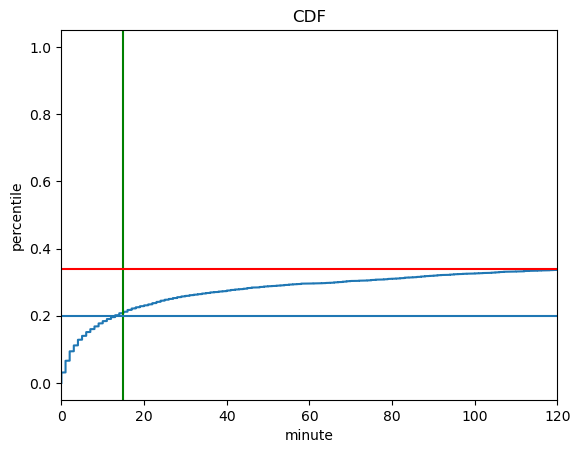

In [66]:
plt.plot(x,y)
plt.xlim( 0, 120 )
plt.axvline ( 15, color = 'g')

plt.axhline( .2)
plt.axhline( .34 , color = 'r')

plt.title('CDF')
plt.ylabel('percentile')
plt.xlabel('minute')

* 상위 20%는 15분 이내에 취소
    * 상위 35% 는 2시간 이내 취소


# 분석 

Text(0.5, 0, 'minute')

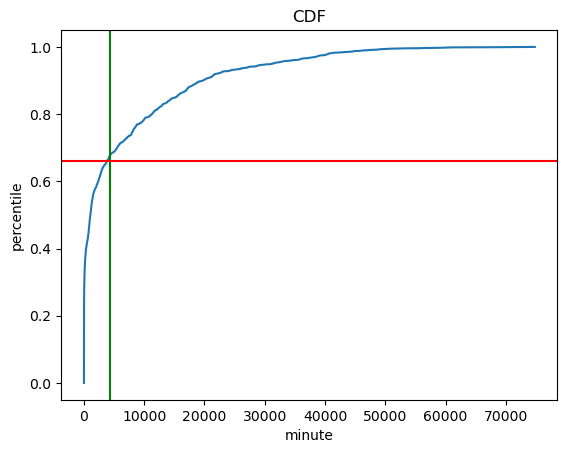

In [67]:
plt.plot( x,y )
# plt.axvline ( 15, color = 'g')
# plt.axvline ( 60*24, color = 'g')
# plt.axvline ( 60*24*2, color = 'g')
plt.axvline ( 60*24*3, color = 'g')
# plt.axhline( .2)
plt.axhline( .66 , color = 'r')
plt.title('CDF')
plt.ylabel('percentile')
plt.xlabel('minute')

* 상위 65%는 3일 이내에 취소

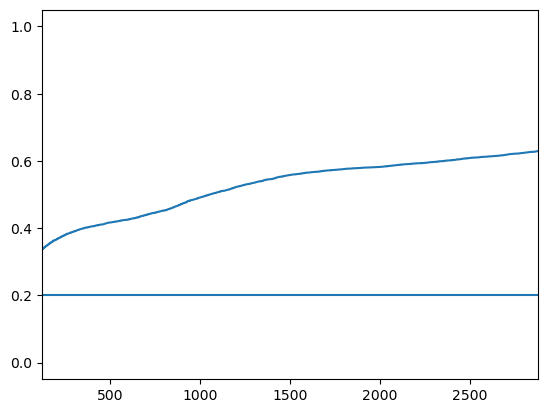

In [44]:
plt.plot(x,y)
plt.xlim( 2*60, 48*60 )
plt.axvline ( .2)
plt.axhline( .2)

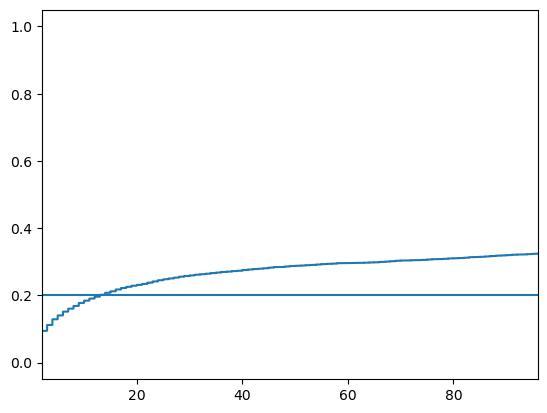

In [40]:
plt.plot(x,y)
plt.xlim( 2, 24*4 )
plt.axvline ( .2)
plt.axhline( .2)

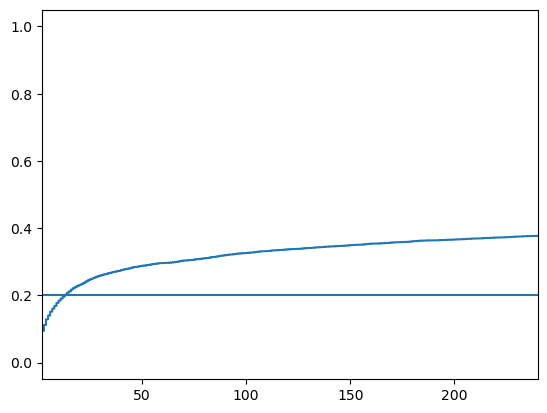

In [41]:
plt.plot(x,y)
plt.xlim( 2, 24*10 )
plt.axvline ( .2)
plt.axhline( .2)

(-1.0, 240.0)

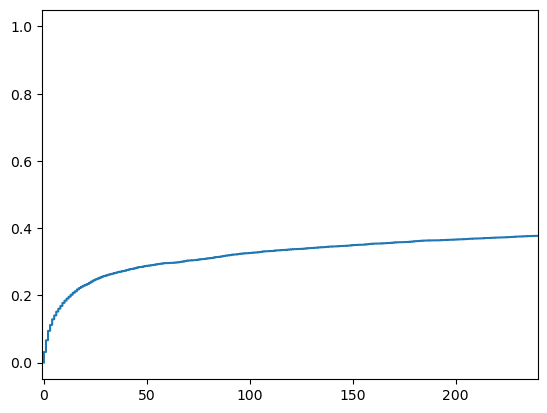

In [42]:
plt.plot(x,y)
plt.xlim( -1, 24*10 )
# plt.axvline ( .2)
# plt.axhline( .2)